# Optimization of DLA structure using inverse design
This file will give you a short tutorial on optimizing a DLA structure.

### Import packages

In [1]:
import numpy as np
import autograd.numpy as npa
from autograd.scipy.signal import convolve as conv

import sys
sys.path.append('../ceviche')

from ceviche import fdfd_hz, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.constants import C_0

import matplotlib.pylab as plt
from skimage.draw import circle

### Physical parameters
First of all, we choose the physical parameters.

In [2]:
wavelength = 2e-6                # wavelength of laser light (m)
beta = 0.5                       # speed of electron / speed of light
omega = 2*np.pi*C_0/wavelength   # angular frequencies (1/s)

### Simulation cell
Next step is to create our simulation cell.

In [3]:
dL = 2e-8                # grid size (m)
npml = [20, 0]           # size of perfectly matched layers
gap = 15                 # gap size for electron beam
spc = 40                 # space between design region and end of cell
pillar_width = 50        # maximal size of our structure
Nx = spc*2 + gap + pillar_width*2 # number of grid cells in x direction
Ny = int(beta*wavelength/dL)      # number of grid cells in y direction
epsr_max = 12            # permittivity of dielectric structure
epsr_min = 1             # vacuum permittivity

Our simulation cell consists of\
space  |  pillar  |  gap  |  pillar  |  space

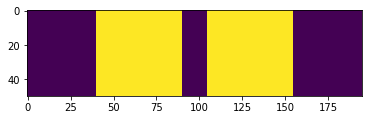

In [4]:
design_region = np.zeros((Nx, Ny))
design_region[spc:spc+pillar_width, :] = 1
design_region[-spc-pillar_width:-spc, :] = 1
plt.imshow(design_region.T)
plt.show()

### Material density and blur function
Instead of directly optimizing the relative permittivity, we will optimize the material density in the design region and convert it afterward.\
This will allow us to blur the structure and thereby increase the feature size.

In [5]:
blur_radius = 7         # smear structure to avoid sharp edges
gamma = 5e2             # make structure binary (vacuum, structure)

def operator_blur(rho, radius, Ny):
    """Blur operator implemented via two-dimensional convolution """
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    kernel=kernel/kernel.sum()
    rho_stack = npa.append(rho, npa.append(rho, rho, axis=1), axis=1)
    conv_rho = conv(rho_stack, kernel, mode='full')[radius:-radius,radius+Ny:2*Ny+radius]
    return conv_rho

def make_rho(rho, design_region, radius, Ny):
    """Helper function for applying the blur to only the design region """
    return rho * (design_region==0).astype(np.float) + operator_blur(rho, radius, Ny) * design_region

def operator_proj(rho, eta, gamma):
    """Density projection """
    return npa.divide(npa.tanh(gamma * eta) + npa.tanh(gamma * (rho - eta)), npa.tanh(gamma * eta) + npa.tanh(gamma * (1 - eta)))

def convert_rho_epsr(rho):
    """ Helper function to convert the material density rho to permittivity eps_r """
    return epsr_min + (epsr_max-epsr_min)*operator_proj(make_rho(rho, design_region, blur_radius, Ny), 0.5, gamma)

rho_init = 0.5 * design_region
eps_r = convert_rho_epsr(rho_init)

### Source term
Now, let's add a source term in the form of an oscillating magnetic dipole in z-direction.

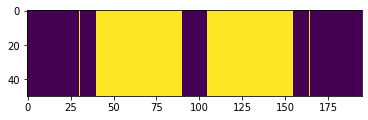

In [6]:
source = np.zeros((Nx, Ny))
source[npml[0]+10, :] = 1     # use just this line for single side drive
source[-npml[0]-10-1, :] = 1  # add this for dual side drive
plt.imshow(source.T + design_region.T)
plt.show()

### Simulation run
We are ready to run the FDFD simulation

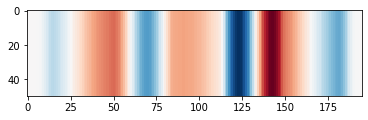

In [7]:
F = fdfd_hz(omega, dL, eps_r, npml)   # create an object that stores our parameters and current structure.
Ex, Ey, Hz = F.solve(source)          # calculate the fields for our source term
plt.imshow(np.real(Hz.T), cmap='RdBu')
plt.show()

### Objective function
In order to run an optimization, we need to define an objective function, which evaluates the quality of the dielectric structure by measuring the acceleration gradient. For this, we define a probe in the center of the electron channel. By introducing a complex wave, we can account for the movement of the electron.

In [8]:
probe = np.zeros((Nx, Ny), dtype=np.complex128)
probe[spc+pillar_width+gap//2:spc+pillar_width+gap//2+2,:] = np.exp(-1j * 2*np.pi * np.arange(Ny)/Ny)

def objective(rho):
    """ Objective function measuring the acceleration gradient """
    eps_arr = convert_rho_epsr(design_region*rho.reshape((Nx, Ny)))
    F.eps_r = eps_arr
    Ex, Ey, Hz = F.solve(source)
    
    G = npa.abs(npa.sum(Ey*probe))  # calculate objective value G
    
    # normalize G by maximum field
    E_mag = npa.sqrt(npa.square(npa.abs(Ex)) + npa.square(npa.abs(Ey)))
    material_density = (eps_r - 1) / (epsr_max - 1)
    max_field = npa.max(E_mag * material_density)
    
    return G/max_field

### Optimization run
Finally, we can actually run the optimization.

In [9]:
N_opts = 50

objective_jac = jacobian(objective, mode='reverse')
(rho_optimum, loss) = adam_optimize(objective, rho_init.flatten(), objective_jac, Nsteps=N_opts, direction='max', step_size=1e-2)

Epoch:   1/ 50 | Duration: 0.38 secs | Value: 1.098499e-12
Epoch:   2/ 50 | Duration: 0.36 secs | Value: 4.770812e+00
Epoch:   3/ 50 | Duration: 0.36 secs | Value: 7.761166e+00
Epoch:   4/ 50 | Duration: 0.39 secs | Value: 1.021890e+01
Epoch:   5/ 50 | Duration: 0.39 secs | Value: 1.336414e+01
Epoch:   6/ 50 | Duration: 0.37 secs | Value: 1.692686e+01
Epoch:   7/ 50 | Duration: 0.46 secs | Value: 2.206222e+01
Epoch:   8/ 50 | Duration: 0.42 secs | Value: 1.613932e+01
Epoch:   9/ 50 | Duration: 0.43 secs | Value: 1.349160e+01
Epoch:  10/ 50 | Duration: 0.42 secs | Value: 1.537059e+01
Epoch:  11/ 50 | Duration: 0.39 secs | Value: 1.965037e+01
Epoch:  12/ 50 | Duration: 0.41 secs | Value: 2.396518e+01
Epoch:  13/ 50 | Duration: 0.47 secs | Value: 2.149602e+01
Epoch:  14/ 50 | Duration: 0.53 secs | Value: 1.797715e+01
Epoch:  15/ 50 | Duration: 0.59 secs | Value: 1.728412e+01
Epoch:  16/ 50 | Duration: 0.44 secs | Value: 1.822899e+01
Epoch:  17/ 50 | Duration: 0.45 secs | Value: 2.113357e+

### Visualization of result
And show the result.

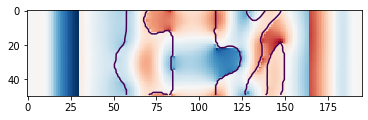

In [38]:
eps_r = convert_rho_epsr(design_region * rho_optimum.reshape((Nx, Ny)))
G = objective(rho_optimum)
F.eps_r = eps_r
Ex, Ey, Hz = F.solve(source)          # calculate the fields for our source term

plt.imshow(np.real(Ey.T), cmap='RdBu')
plt.contour(eps_r.T, levels=[(epsr_max+1)/2])
plt.show()